## ESMACS binding free energy application

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the ESMACS application. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [56]:
#!pip install easysurrogate==0.24.1

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [58]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [59]:
%matplotlib inline
# save figures at 300 dpi
plt.rcParams['savefig.dpi'] = 300

### Load prior ranges

The JSON files below contains all default values and boundaries used for specifying the Uniform input parameter distributions. 

In [60]:
# Load the EasyVVUQ params dicts, containing the default values and type of each input
priors = {}
# there are 5 inputs files, each with a seperate params dict
prior_fnames = os.listdir('./priors')
for fname in prior_fnames:
    prior = json.load(open('./priors/%s' % fname, 'r'))
    priors = priors | prior
priors

{'d01fc': {'default': 0.75, 'type': 'float'},
 'd02fc': {'default': 0.25, 'type': 'float'},
 'd03fc': {'default': 0.092, 'type': 'float'},
 'd04fc': {'default': 0.612, 'type': 'float'},
 'd05fc': {'default': 0.252, 'type': 'float'},
 'd06fc': {'default': 0.03, 'type': 'float'},
 'd07fc': {'default': 0.154, 'type': 'float'},
 'd08fc': {'default': 0.486, 'type': 'float'},
 'd09fc': {'default': 0.033, 'type': 'float'},
 'd10fc': {'default': 1.0, 'type': 'float'},
 'd11fc': {'default': 0.45, 'type': 'float'},
 'd12fc': {'default': 0.0, 'type': 'float'},
 'd13fc': {'default': 0.53, 'type': 'float'},
 'd14fc': {'default': 0.15, 'type': 'float'},
 'd15fc': {'default': 0.5, 'type': 'float'},
 'd16fc': {'default': 1.5, 'type': 'float'},
 'd17fc': {'default': 1.05, 'type': 'float'},
 'd18fc': {'default': 10.5, 'type': 'float'},
 'd19fc': {'default': 1.1, 'type': 'float'},
 'd20fc': {'default': 1.0, 'type': 'float'},
 'box_size': {'default': 14.0, 'type': 'float'},
 'cutoff': {'default': 12.0, 't

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [61]:
# input parameters
params = pd.read_csv('./data_esmacs/esmacs_inputs.csv')
param_names = params.keys()
params = params.values

# number of code samples
n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])

# except the temperature
idx_T = np.where(param_names == 'setTemperature')[0]
p_max[idx_T] = np.array(priors['setTemperature']['default'] * 1.075)
p_min[idx_T] = np.array(priors['setTemperature']['default'] * 0.925)

# scale inputs within [-1, 1]
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

Load the corresponding Monte Carlo outputs, in the case the binding free energy predictions.

In [62]:
QoI = 'binding_energy'
output = pd.read_csv('./data_esmacs/%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [63]:
# average the data over the replica simulations or not
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [64]:
d = 1

### Set hyperparameters

In [65]:
# number of neurons per hidden layer 
n_hidden_neurons = 20
# number of hidden layer + output layer
n_layers = 3
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [66]:
test_frac = 0.1
test_idx = int((1 - test_frac) * n_samples)
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [67]:
n_rep = 20

### Train a deep active subspace network


In [68]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [69]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
        # W_1 = das_surrogate.neural_net.layers[1].W
        # results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.5`.

In [70]:
train_das(failure_criterion=0.5)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  662/662 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 167
Loss function = squared
Number of neurons per hidden layer = 20
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 228 weights.
Training Deep Active Subspace Neural Network...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 390.74it/s]


 loss = 2.2775
Relative training error = 22.1737 %
Relative test error = 21.6835 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 1.0854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 307.10it/s]


Relative training error = 18.9830 %
Relative test error = 19.4294 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.18it/s]


 loss = 0.8558
Relative training error = 15.9114 %
Relative test error = 17.8244 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 559.42it/s]

 loss = 0.3210
Relative training error = 13.6193 %
Relative test error = 15.3566 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 443.09it/s]

 loss = 0.2766
Relative training error = 11.8861 %


Relative test error = 12.4138 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 534.69it/s]


 loss = 0.2404
Relative training error = 10.6490 %
Relative test error = 10.7715 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 515.53it/s]

 loss = 0.2278
Relative training error = 9.8894 %
Relative test error = 9.6621 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 538.33it/s]


 loss = 0.1300
Relative training error = 9.3704 %
Relative test error = 9.3406 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 494.13it/s]


 loss = 0.1941
Relative training error = 8.9172 %
Relative test error = 9.3049 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 442.20it/s]

 loss = 0.1891


Relative training error = 8.6599 %
Relative test error = 9.3114 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.0890


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 329.47it/s]


Relative training error = 8.4519 %
Relative test error = 9.0292 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1463


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 425.84it/s]


Relative training error = 8.3545 %
Relative test error = 9.1245 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 413.98it/s]

 loss = 0.1531


Relative training error = 8.3038 %
Relative test error = 9.5398 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 556.36it/s]

 loss = 0.0991


Relative training error = 8.1846 %
Relative test error = 9.0869 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 521.58it/s]

 loss = 0.1459


Relative training error = 8.1632 %
Relative test error = 9.3914 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 487.56it/s]

 loss = 0.1203


Relative training error = 8.1508 %
Relative test error = 9.5861 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 521.21it/s]

 loss = 0.1301


Relative training error = 8.1072 %
Relative test error = 9.2879 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 509.29it/s]

 loss = 0.1267


Relative training error = 8.1066 %
Relative test error = 9.1323 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.88it/s]

 loss = 0.0849


Relative training error = 8.0829 %
Relative test error = 9.1585 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 499.06it/s]

 loss = 0.0977


Relative training error = 8.1178 %
Relative test error = 9.3750 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 518.03it/s]

 loss = 0.0689


Relative training error = 8.1339 %
Relative test error = 9.2384 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.92it/s]


 loss = 0.1312
Relative training error = 8.1155 %
Relative test error = 9.5495 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.98it/s]


 loss = 0.1535
Relative training error = 8.1067 %
Relative test error = 9.3119 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 510.42it/s]


 loss = 0.0720
Relative training error = 8.0941 %
Relative test error = 9.3059 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.11it/s]


 loss = 0.0979
Relative training error = 8.0583 %
Relative test error = 9.2457 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.49it/s]


 loss = 0.1329
Relative training error = 8.0206 %
Relative test error = 9.2183 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.79it/s]


 loss = 0.1024
Relative training error = 8.0314 %
Relative test error = 9.4095 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.09it/s]


 loss = 0.8891
Relative training error = 22.8131 %
Relative test error = 22.1826 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 574.37it/s]

 loss = 1.4067
Relative training error = 19.8713 %
Relative test error = 20.7066 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.49it/s]


 loss = 0.6544
Relative training error = 16.8960 %
Relative test error = 18.7533 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.68it/s]


 loss = 0.6805
Relative training error = 14.8065 %
Relative test error = 16.9024 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 472.07it/s]


 loss = 0.5331
Relative training error = 12.8413 %
Relative test error = 14.3168 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 507.00it/s]

 loss = 0.3903


Relative training error = 11.2983 %
Relative test error = 12.3428 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.26it/s]


 loss = 0.3137
Relative training error = 10.2408 %
Relative test error = 11.2842 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 444.45it/s]

 loss = 0.2375


Relative training error = 9.5814 %
Relative test error = 10.9043 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.01it/s]

 loss = 0.1990
Relative training error = 9.0943 %
Relative test error = 10.3366 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 478.09it/s]

 loss = 0.1840
Relative training error = 8.7608 %
Relative test error = 10.0038 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 549.52it/s]


 loss = 0.1342
Relative training error = 8.6425 %
Relative test error = 9.6603 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 494.93it/s]


 loss = 0.1123
Relative training error = 8.4506 %
Relative test error = 9.8600 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.41it/s]


 loss = 0.1949
Relative training error = 8.4085 %
Relative test error = 9.8785 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 495.19it/s]


 loss = 0.1602
Relative training error = 8.3937 %
Relative test error = 10.3235 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.71it/s]


 loss = 0.1302
Relative training error = 8.3304 %
Relative test error = 10.2889 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.49it/s]

 loss = 1.0110
Relative training error = 21.1496 %


Relative test error = 21.9080 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 433.28it/s]


 loss = 0.7497
Relative training error = 16.6696 %
Relative test error = 19.1471 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.79it/s]

 loss = 0.4587


Relative training error = 12.5902 %
Relative test error = 14.9949 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.80it/s]

 loss = 0.3824


Relative training error = 10.3444 %
Relative test error = 12.1607 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 425.33it/s]

 loss = 0.1873


Relative training error = 9.1475 %
Relative test error = 10.6786 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.88it/s]


 loss = 0.1727
Relative training error = 8.6375 %
Relative test error = 10.5060 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.97it/s]

 loss = 0.1286


Relative training error = 8.3941 %
Relative test error = 10.3164 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 469.97it/s]

 loss = 0.0780


Relative training error = 8.3141 %
Relative test error = 10.0980 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 505.33it/s]

 loss = 0.0811


Relative training error = 8.2549 %
Relative test error = 9.7879 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1643


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 277.94it/s]


Relative training error = 8.1413 %
Relative test error = 9.9046 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1331


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.07it/s]

Relative training error = 8.1488 %


Relative test error = 9.6964 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.81it/s]

 loss = 0.1702


Relative training error = 8.1215 %
Relative test error = 10.0845 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.41it/s]


 loss = 0.1327
Relative training error = 8.0705 %
Relative test error = 9.9380 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 543.07it/s]

 loss = 0.1145


Relative training error = 8.0440 %
Relative test error = 9.7596 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 544.08it/s]


 loss = 0.1488
Relative training error = 8.0561 %
Relative test error = 9.9399 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 436.73it/s]


 loss = 0.1003
Relative training error = 8.0862 %
Relative test error = 9.7355 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.68it/s]


 loss = 0.1220
Relative training error = 8.0541 %
Relative test error = 9.4990 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.51it/s]

 loss = 0.0790
Relative training error = 8.0166 %


Relative test error = 9.6125 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 476.48it/s]


 loss = 0.1330
Relative training error = 8.0104 %
Relative test error = 9.9225 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 521.81it/s]


 loss = 0.0788
Relative training error = 7.9976 %
Relative test error = 9.9482 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 571.15it/s]

 loss = 0.1221
Relative training error = 8.0032 %
Relative test error = 9.9548 %


Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02662707  0.00106644 -0.01827304 -0.01481842
  0.00496895 -0.0175265

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.11it/s]


 loss = 1.4750
Relative training error = 24.5575 %
Relative test error = 23.1756 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 1.0429


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.38it/s]


Relative training error = 21.5495 %
Relative test error = 21.6679 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.58it/s]


 loss = 0.5518
Relative training error = 17.7319 %
Relative test error = 19.0322 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 525.61it/s]


 loss = 0.4143
Relative training error = 13.9213 %
Relative test error = 16.2200 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.86it/s]


 loss = 0.2737
Relative training error = 11.3076 %
Relative test error = 13.0482 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 573.77it/s]


 loss = 0.2046
Relative training error = 10.1078 %
Relative test error = 11.4978 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.66it/s]


 loss = 0.2891
Relative training error = 9.2722 %
Relative test error = 10.6825 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 476.30it/s]


 loss = 0.1503
Relative training error = 8.9002 %
Relative test error = 10.4303 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.28it/s]


 loss = 0.0913
Relative training error = 8.7207 %
Relative test error = 9.9370 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 556.06it/s]


 loss = 0.1084
Relative training error = 8.5133 %
Relative test error = 10.0239 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 533.39it/s]


 loss = 0.0902
Relative training error = 8.4154 %
Relative test error = 10.0482 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 555.36it/s]


 loss = 0.1814
Relative training error = 8.2786 %
Relative test error = 9.9075 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.97it/s]


 loss = 0.0825
Relative training error = 8.2199 %
Relative test error = 9.8174 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 591.77it/s]


 loss = 0.2039
Relative training error = 8.1932 %
Relative test error = 9.8159 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 513.66it/s]


 loss = 0.0976
Relative training error = 8.2206 %
Relative test error = 9.8229 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 572.18it/s]


 loss = 0.1260
Relative training error = 8.1425 %
Relative test error = 9.4689 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 511.92it/s]


 loss = 1.3729
Relative training error = 22.9282 %
Relative test error = 22.0903 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.8435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 394.35it/s]


Relative training error = 20.4532 %
Relative test error = 20.5374 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.8939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 249.92it/s]


Relative training error = 16.9877 %
Relative test error = 19.0047 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.4163


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 402.87it/s]


Relative training error = 14.5473 %
Relative test error = 17.6217 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 406.71it/s]

 loss = 0.3937


Relative training error = 12.8014 %
Relative test error = 15.2598 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.16it/s]

 loss = 0.2532


Relative training error = 11.6923 %
Relative test error = 14.1657 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 477.89it/s]

 loss = 0.2500


Relative training error = 10.7510 %
Relative test error = 12.9515 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.78it/s]

 loss = 0.1965


Relative training error = 10.0618 %
Relative test error = 11.9437 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.2357


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 343.52it/s]


Relative training error = 9.5138 %
Relative test error = 10.9094 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.71it/s]

 loss = 0.1516


Relative training error = 9.1441 %
Relative test error = 10.3809 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 442.27it/s]


 loss = 0.1009
Relative training error = 9.0128 %
Relative test error = 10.1261 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 510.62it/s]

 loss = 0.1722


Relative training error = 8.7408 %
Relative test error = 9.6188 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 434.26it/s]


 loss = 0.1149
Relative training error = 8.5861 %
Relative test error = 9.8518 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.80it/s]

 loss = 0.1436


Relative training error = 8.4221 %
Relative test error = 9.8388 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 521.01it/s]


 loss = 0.1498
Relative training error = 8.4046 %
Relative test error = 9.8416 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 512.58it/s]

 loss = 0.1500


Relative training error = 8.4042 %
Relative test error = 9.8326 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 516.01it/s]

 loss = 1.6853


Relative training error = 24.1641 %
Relative test error = 23.6576 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.53it/s]

 loss = 1.2921


Relative training error = 22.8218 %
Relative test error = 22.2689 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.72it/s]

 loss = 1.0064


Relative training error = 20.8072 %
Relative test error = 21.5391 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 546.96it/s]

 loss = 0.8800


Relative training error = 17.6635 %
Relative test error = 20.2981 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.84it/s]

 loss = 0.4906
Relative training error = 14.6113 %


Relative test error = 17.7490 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 495.52it/s]

 loss = 0.4865


Relative training error = 12.4678 %
Relative test error = 16.0233 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.26it/s]

 loss = 0.1414


Relative training error = 11.2150 %
Relative test error = 14.2402 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.69it/s]

 loss = 0.1363
Relative training error = 10.2974 %
Relative test error = 12.2860 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.30it/s]

 loss = 0.1339
Relative training error = 9.6807 %


Relative test error = 11.1685 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.41it/s]

 loss = 0.2007


Relative training error = 9.1180 %
Relative test error = 10.1904 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 557.87it/s]


 loss = 0.1383
Relative training error = 8.6929 %
Relative test error = 10.1069 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.44it/s]

 loss = 0.1249


Relative training error = 8.5181 %
Relative test error = 9.6805 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.64it/s]


 loss = 0.0844
Relative training error = 8.4170 %
Relative test error = 9.9085 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 471.07it/s]

 loss = 0.1007


Relative training error = 8.2618 %
Relative test error = 9.7286 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.75it/s]


 loss = 0.1028
Relative training error = 8.2472 %
Relative test error = 9.6788 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 549.04it/s]

 loss = 0.1397


Relative training error = 8.2439 %
Relative test error = 9.7071 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 536.48it/s]

 loss = 0.0664
Relative training error = 8.1338 %
Relative test error = 9.7861 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 533.98it/s]

 loss = 0.1201
Relative training error = 8.0930 %


Relative test error = 9.7393 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02662707  0.00106644 -0.01827304 -0.0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 545.36it/s]


 loss = 1.2126
Relative training error = 23.6532 %
Relative test error = 22.9599 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 1.0859


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 514.69it/s]

Relative training error = 23.2382 %


Relative test error = 23.0765 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 420.24it/s]


 loss = 1.5697
Relative training error = 21.9615 %
Relative test error = 22.4926 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 426.53it/s]


 loss = 0.6032
Relative training error = 19.8841 %
Relative test error = 21.2184 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.35it/s]

 loss = 0.8776


Relative training error = 17.0439 %
Relative test error = 19.7364 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.30it/s]

 loss = 0.5781


Relative training error = 14.4042 %
Relative test error = 17.5077 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 417.07it/s]

 loss = 0.2882


Relative training error = 12.1533 %
Relative test error = 14.5802 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 436.26it/s]

 loss = 0.2124


Relative training error = 10.9955 %
Relative test error = 12.6119 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 519.74it/s]

 loss = 0.1431


Relative training error = 10.2729 %
Relative test error = 11.1953 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.87it/s]

 loss = 0.1751


Relative training error = 9.7495 %
Relative test error = 11.0230 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 543.34it/s]


 loss = 0.1287
Relative training error = 9.3397 %
Relative test error = 10.4567 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.36it/s]


 loss = 0.2044
Relative training error = 9.0267 %
Relative test error = 10.4909 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.05it/s]

 loss = 0.1795


Relative training error = 8.8703 %
Relative test error = 9.9255 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 421.29it/s]


 loss = 0.1374
Relative training error = 8.7012 %
Relative test error = 10.0460 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 438.22it/s]

 loss = 0.0946


Relative training error = 8.5695 %
Relative test error = 9.7919 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.70it/s]

 loss = 0.1904


Relative training error = 8.5120 %
Relative test error = 9.9052 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.50it/s]

 loss = 0.1190


Relative training error = 8.5137 %
Relative test error = 10.0078 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.19it/s]

 loss = 0.0700


Relative training error = 8.4078 %
Relative test error = 9.6115 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.21it/s]

 loss = 0.1256


Relative training error = 8.3888 %
Relative test error = 9.7845 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 560.77it/s]


 loss = 0.1389
Relative training error = 8.3699 %
Relative test error = 10.0276 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.13it/s]

 loss = 0.1330


Relative training error = 8.3625 %
Relative test error = 9.9219 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.0803


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 262.66it/s]


Relative training error = 8.3209 %
Relative test error = 9.7280 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.2103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 433.08it/s]


Relative training error = 8.3066 %
Relative test error = 9.8314 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.40it/s]

 loss = 0.1796


Relative training error = 8.2931 %
Relative test error = 9.7064 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 433.35it/s]

 loss = 0.1200


Relative training error = 8.2085 %
Relative test error = 9.6894 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 423.88it/s]

 loss = 0.0851


Relative training error = 8.2298 %
Relative test error = 9.5456 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 418.78it/s]

 loss = 0.1050


Relative training error = 8.2371 %
Relative test error = 9.5612 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 531.75it/s]

 loss = 0.1042


Relative training error = 8.2283 %
Relative test error = 9.5332 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 565.93it/s]

 loss = 0.1421
Relative training error = 8.1590 %
Relative test error = 9.6033 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 442.22it/s]

 loss = 0.1037


Relative training error = 8.1156 %
Relative test error = 9.5786 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 556.63it/s]

 loss = 1.7860
Relative training error = 23.1969 %
Relative test error = 22.4396 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 528.80it/s]

 loss = 1.1419
Relative training error = 20.4316 %


Relative test error = 20.9770 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 442.68it/s]


 loss = 1.1687
Relative training error = 18.1508 %
Relative test error = 19.1423 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 402.84it/s]

 loss = 0.5499


Relative training error = 15.4629 %
Relative test error = 17.2352 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.82it/s]

 loss = 0.4359


Relative training error = 12.9382 %
Relative test error = 15.1610 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.45it/s]

 loss = 0.2325


Relative training error = 11.2138 %
Relative test error = 13.5591 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.19it/s]

 loss = 0.2099


Relative training error = 10.1824 %
Relative test error = 12.7129 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 554.91it/s]

 loss = 0.2438


Relative training error = 9.4659 %
Relative test error = 11.5753 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 532.63it/s]

 loss = 0.1071


Relative training error = 9.0308 %
Relative test error = 10.8172 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.44it/s]

 loss = 0.1740
Relative training error = 8.6866 %
Relative test error = 10.3346 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.65it/s]

 loss = 0.1121
Relative training error = 8.3993 %


Relative test error = 10.4300 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.45it/s]


 loss = 0.1428
Relative training error = 8.3110 %
Relative test error = 10.1894 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 538.70it/s]

 loss = 0.1970


Relative training error = 8.1824 %
Relative test error = 9.8508 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 538.96it/s]

 loss = 0.1262


Relative training error = 8.1417 %
Relative test error = 9.8929 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 560.89it/s]


 loss = 0.0953
Relative training error = 8.1029 %
Relative test error = 10.0899 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.83it/s]

 loss = 0.1104


Relative training error = 8.1419 %
Relative test error = 9.4767 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.43it/s]


 loss = 0.0874
Relative training error = 8.0465 %
Relative test error = 9.3200 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 508.03it/s]

 loss = 0.0944


Relative training error = 8.0716 %
Relative test error = 9.3462 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.71it/s]

 loss = 0.0767


Relative training error = 8.0578 %
Relative test error = 9.4920 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.58it/s]

 loss = 0.0712


Relative training error = 8.0798 %
Relative test error = 9.2051 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.66it/s]


 loss = 0.1159
Relative training error = 8.1309 %
Relative test error = 9.1640 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.03it/s]

 loss = 0.1778


Relative training error = 8.0046 %
Relative test error = 9.5864 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 435.25it/s]


 loss = 0.1350
Relative training error = 8.0195 %
Relative test error = 9.7544 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.75it/s]

 loss = 0.1133


Relative training error = 7.9726 %
Relative test error = 10.1246 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 494.34it/s]

 loss = 1.6295


Relative training error = 22.1053 %
Relative test error = 21.6948 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 418.00it/s]


 loss = 0.7355
Relative training error = 18.3160 %
Relative test error = 19.5621 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 418.37it/s]

 loss = 0.6773


Relative training error = 14.8812 %
Relative test error = 16.9362 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 430.41it/s]

 loss = 0.4458


Relative training error = 12.7332 %
Relative test error = 13.8641 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 425.21it/s]

 loss = 0.4034


Relative training error = 11.0160 %
Relative test error = 12.3100 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 495.64it/s]

 loss = 0.1417


Relative training error = 9.8431 %
Relative test error = 11.6913 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 413.62it/s]

 loss = 0.1459


Relative training error = 9.0729 %
Relative test error = 10.8544 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 425.45it/s]

 loss = 0.1646


Relative training error = 8.7223 %
Relative test error = 10.6602 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 423.49it/s]

 loss = 0.1012


Relative training error = 8.5309 %
Relative test error = 10.6511 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.85it/s]

 loss = 0.1364


Relative training error = 8.3956 %
Relative test error = 10.5490 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.0714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 286.16it/s]


Relative training error = 8.3282 %
Relative test error = 10.0934 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 428.59it/s]


Relative training error = 8.2504 %
Relative test error = 9.8069 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.55it/s]

 loss = 0.0951
Relative training error = 8.1785 %


Relative test error = 9.7572 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 428.75it/s]

 loss = 0.1255


Relative training error = 8.1926 %
Relative test error = 9.7545 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 389.25it/s]

 loss = 0.1271


Relative training error = 8.0947 %
Relative test error = 9.8487 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.0961


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 433.98it/s]


Relative training error = 8.0992 %
Relative test error = 9.6955 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 574.94it/s]


 loss = 1.3833
Relative training error = 23.4026 %
Relative test error = 22.6582 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 471.80it/s]

 loss = 0.9690
Relative training error = 20.4174 %


Relative test error = 21.5971 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 473.49it/s]


 loss = 0.6227
Relative training error = 17.3913 %
Relative test error = 19.0230 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.14it/s]

 loss = 0.4604


Relative training error = 15.2126 %
Relative test error = 16.7741 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 419.80it/s]

 loss = 0.5204


Relative training error = 13.4572 %
Relative test error = 14.5519 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 486.85it/s]

 loss = 0.1999


Relative training error = 11.7488 %
Relative test error = 12.7601 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 443.17it/s]

 loss = 0.1197
Relative training error = 10.5752 %


Relative test error = 12.0088 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 429.03it/s]

 loss = 0.0976


Relative training error = 9.7779 %
Relative test error = 10.8365 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.27it/s]


 loss = 0.1061
Relative training error = 9.4066 %
Relative test error = 10.5051 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 349.00it/s]

 loss = 0.2225


Relative training error = 9.0469 %
Relative test error = 10.3329 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1260


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 403.60it/s]


Relative training error = 8.8707 %
Relative test error = 10.1397 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 297.58it/s]


Relative training error = 8.7557 %
Relative test error = 10.0325 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1676


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 538.78it/s]


Relative training error = 8.6286 %
Relative test error = 9.8294 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 548.21it/s]

 loss = 0.1446
Relative training error = 8.4853 %
Relative test error = 10.0999 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.14it/s]


 loss = 0.1426
Relative training error = 8.4335 %
Relative test error = 9.8047 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 442.72it/s]


 loss = 0.0736
Relative training error = 8.3519 %
Relative test error = 9.7678 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 403.17it/s]


 loss = 0.1422
Relative training error = 8.3831 %
Relative test error = 9.8462 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 385.15it/s]

 loss = 0.1031


Relative training error = 8.3503 %
Relative test error = 9.6018 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.0990


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 390.64it/s]


Relative training error = 8.2874 %
Relative test error = 9.8250 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 419.17it/s]

 loss = 0.1616


Relative training error = 8.2952 %
Relative test error = 9.6462 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 443.38it/s]

 loss = 0.1516


Relative training error = 8.2790 %
Relative test error = 9.9200 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 546.36it/s]

 loss = 0.0827


Relative training error = 8.2864 %
Relative test error = 9.4170 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 441.70it/s]

 loss = 0.0972


Relative training error = 8.2277 %
Relative test error = 9.3043 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.53it/s]

 loss = 0.1205


Relative training error = 8.2091 %
Relative test error = 9.4008 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.12it/s]

 loss = 0.1592


Relative training error = 8.2470 %
Relative test error = 9.6790 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 496.36it/s]

 loss = 0.1428


Relative training error = 8.1489 %
Relative test error = 9.5214 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 560.84it/s]

 loss = 0.1423


Relative training error = 8.1610 %
Relative test error = 9.5822 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.97it/s]

 loss = 0.1336
Relative training error = 8.1545 %
Relative test error = 9.6320 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 552.42it/s]

 loss = 0.0979


Relative training error = 8.1841 %
Relative test error = 9.7513 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.37it/s]


 loss = 0.1027
Relative training error = 8.1809 %
Relative test error = 9.8664 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 552.47it/s]


 loss = 1.3647
Relative training error = 23.7580 %
Relative test error = 23.1665 %


 loss = 0.7783


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.97it/s]


Relative training error = 23.6356 %
Relative test error = 23.5174 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 341.06it/s]


 loss = 1.3967
Relative training error = 22.4856 %
Relative test error = 23.3884 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.7749


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.60it/s]


Relative training error = 21.5696 %
Relative test error = 23.1414 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.79it/s]

 loss = 0.6716


Relative training error = 20.2412 %
Relative test error = 22.6042 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.07it/s]

 loss = 0.6396


Relative training error = 18.0118 %
Relative test error = 21.5994 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.23it/s]

 loss = 0.6983


Relative training error = 15.7203 %
Relative test error = 19.5476 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.52it/s]

 loss = 0.7932


Relative training error = 13.3973 %
Relative test error = 16.4363 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 540.16it/s]


 loss = 0.2422
Relative training error = 11.8043 %
Relative test error = 14.0790 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.49it/s]


 loss = 0.2375
Relative training error = 10.6200 %
Relative test error = 12.3955 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 498.86it/s]


 loss = 0.1465
Relative training error = 9.9183 %
Relative test error = 10.9683 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 486.31it/s]


 loss = 0.0959
Relative training error = 9.4122 %
Relative test error = 10.3605 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 472.19it/s]

 loss = 0.0931


Relative training error = 8.9797 %
Relative test error = 10.0375 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.48it/s]

 loss = 0.1019


Relative training error = 8.7141 %
Relative test error = 9.8701 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.32it/s]


 loss = 0.0915
Relative training error = 8.5471 %
Relative test error = 9.4392 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 563.08it/s]

 loss = 0.1706


Relative training error = 8.4494 %
Relative test error = 9.2317 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 500.54it/s]


 loss = 0.0958
Relative training error = 8.3393 %
Relative test error = 9.4777 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 476.00it/s]

 loss = 0.0661


Relative training error = 8.3213 %
Relative test error = 9.4474 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.36it/s]


 loss = 0.1185
Relative training error = 8.2728 %
Relative test error = 9.5445 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 526.52it/s]

 loss = 0.1351


Relative training error = 8.2051 %
Relative test error = 9.4977 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 399.36it/s]

 loss = 0.7000


Relative training error = 21.7385 %
Relative test error = 20.8819 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 422.63it/s]

 loss = 0.8246


Relative training error = 16.3972 %
Relative test error = 17.7290 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 408.44it/s]

 loss = 0.2658


Relative training error = 12.8487 %
Relative test error = 16.1456 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 515.54it/s]

 loss = 0.4916


Relative training error = 11.0924 %
Relative test error = 13.4988 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.01it/s]

 loss = 0.2523


Relative training error = 9.9437 %
Relative test error = 11.6894 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.06it/s]

 loss = 0.2430


Relative training error = 9.3011 %
Relative test error = 10.8384 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 580.75it/s]

 loss = 0.1631


Relative training error = 9.0238 %
Relative test error = 10.5952 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.60it/s]

 loss = 0.1073


Relative training error = 8.8717 %
Relative test error = 10.3950 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 454.58it/s]

 loss = 0.1696


Relative training error = 8.6479 %
Relative test error = 10.4025 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.45it/s]

 loss = 0.1216


Relative training error = 8.4547 %
Relative test error = 10.2375 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 545.26it/s]

 loss = 0.1748
Relative training error = 8.5151 %


Relative test error = 10.2398 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.33it/s]

 loss = 0.1110


Relative training error = 8.4428 %
Relative test error = 9.7941 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.56it/s]


 loss = 0.1333
Relative training error = 8.3851 %
Relative test error = 9.3155 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.63it/s]

 loss = 0.0659


Relative training error = 8.3468 %
Relative test error = 9.2385 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 486.71it/s]


 loss = 0.1452
Relative training error = 8.3426 %
Relative test error = 9.6565 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 421.37it/s]

 loss = 0.1790


Relative training error = 8.2702 %
Relative test error = 9.6888 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 392.07it/s]

 loss = 0.1040


Relative training error = 8.2306 %
Relative test error = 9.6511 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 485.13it/s]

 loss = 1.5258
Relative training error = 24.0047 %
Relative test error = 23.0660 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 575.75it/s]

 loss = 0.7945
Relative training error = 23.2482 %
Relative test error = 22.9329 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.27it/s]


 loss = 1.0357
Relative training error = 22.8289 %
Relative test error = 22.7895 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 477.27it/s]


 loss = 0.9711
Relative training error = 22.5341 %
Relative test error = 22.9058 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 386.84it/s]


 loss = 0.9290
Relative training error = 22.2485 %
Relative test error = 23.1179 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.23it/s]

 loss = 1.1020


Relative training error = 22.0217 %
Relative test error = 23.0660 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 412.89it/s]

 loss = 0.7656


Relative training error = 21.6827 %
Relative test error = 23.0386 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 435.55it/s]

 loss = 0.6556
Relative training error = 21.5802 %
Relative test error = 22.0884 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.90it/s]

 loss = 0.9160


Relative training error = 18.7482 %
Relative test error = 20.6445 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.70it/s]


 loss = 0.6445
Relative training error = 15.4687 %
Relative test error = 18.9467 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 430.19it/s]

 loss = 0.3390


Relative training error = 13.0105 %
Relative test error = 16.2594 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 419.36it/s]

 loss = 0.3199


Relative training error = 11.3822 %
Relative test error = 13.9712 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 422.75it/s]

 loss = 0.2988


Relative training error = 10.1724 %
Relative test error = 12.2760 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 423.42it/s]

 loss = 0.0810


Relative training error = 9.5110 %
Relative test error = 10.8805 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 432.79it/s]

 loss = 0.2137


Relative training error = 9.0371 %
Relative test error = 10.6663 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 481.47it/s]

 loss = 0.1917


Relative training error = 8.6680 %
Relative test error = 10.0557 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 492.39it/s]

 loss = 0.1421


Relative training error = 8.4457 %
Relative test error = 9.8750 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.95it/s]

 loss = 0.0678


Relative training error = 8.3372 %
Relative test error = 9.6665 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.72it/s]

 loss = 0.1129


Relative training error = 8.2862 %
Relative test error = 9.8761 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 493.49it/s]

 loss = 0.1445


Relative training error = 8.1723 %
Relative test error = 9.9245 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.52it/s]


 loss = 0.1484
Relative training error = 8.1645 %
Relative test error = 9.8916 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 602.87it/s]

 loss = 0.1227
Relative training error = 8.1784 %
Relative test error = 10.0148 %


Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02662707  0.00106644 -0.01827304 -0.01481842
  0.00496895 -0.0175265

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 419.81it/s]

 loss = 0.8720


Relative training error = 23.6301 %
Relative test error = 23.2050 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.74it/s]


 loss = 1.1329
Relative training error = 22.6605 %
Relative test error = 23.2148 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 401.33it/s]

 loss = 0.9508


Relative training error = 21.4799 %
Relative test error = 22.8125 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.8104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 306.02it/s]


Relative training error = 20.0274 %
Relative test error = 21.9738 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 1.1093


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.80it/s]


Relative training error = 17.9642 %
Relative test error = 20.4651 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.18it/s]

 loss = 0.5720


Relative training error = 15.4375 %
Relative test error = 19.2580 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 474.05it/s]

 loss = 0.3556


Relative training error = 13.4151 %
Relative test error = 16.7619 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 475.70it/s]

 loss = 0.2823


Relative training error = 11.7276 %
Relative test error = 14.9274 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 488.81it/s]

 loss = 0.1974
Relative training error = 10.5961 %


Relative test error = 13.6376 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 564.39it/s]

 loss = 0.1175
Relative training error = 9.7281 %


Relative test error = 12.0265 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.57it/s]

 loss = 0.1499


Relative training error = 9.1728 %
Relative test error = 11.2287 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.83it/s]


 loss = 0.1872
Relative training error = 8.7594 %
Relative test error = 10.7197 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.24it/s]

 loss = 0.1620


Relative training error = 8.5080 %
Relative test error = 10.6395 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 540.13it/s]

 loss = 0.1023


Relative training error = 8.3564 %
Relative test error = 10.2302 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.26it/s]

 loss = 0.1341


Relative training error = 8.2563 %
Relative test error = 10.1543 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.63it/s]

 loss = 0.1018


Relative training error = 8.1721 %
Relative test error = 10.0472 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.60it/s]

 loss = 0.0671


Relative training error = 8.1984 %
Relative test error = 9.9428 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.52it/s]

 loss = 0.0883


Relative training error = 8.1037 %
Relative test error = 10.0315 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 546.59it/s]

 loss = 0.1292
Relative training error = 8.0694 %
Relative test error = 9.7048 %

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.83it/s]


 loss = 0.1110
Relative training error = 8.0125 %
Relative test error = 9.7673 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 430.87it/s]


 loss = 0.1089
Relative training error = 8.0123 %
Relative test error = 9.8726 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 432.51it/s]

 loss = 0.0793


Relative training error = 8.0920 %
Relative test error = 9.6703 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 435.02it/s]


 loss = 0.1323
Relative training error = 8.0193 %
Relative test error = 9.5725 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 409.18it/s]

 loss = 0.1167


Relative training error = 7.9712 %
Relative test error = 9.5469 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 474.07it/s]

 loss = 0.0842
Relative training error = 7.9864 %


Relative test error = 9.6954 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 597.88it/s]

 loss = 0.0993
Relative training error = 7.9555 %
Relative test error = 9.7023 %


Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02662707  0.00106644 -0.01827304 -0.01481842
  0.00496895 -0.0175265

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 440.08it/s]

 loss = 0.9631


Relative training error = 22.5997 %
Relative test error = 22.3945 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.09it/s]


 loss = 0.8064
Relative training error = 20.6827 %
Relative test error = 20.7176 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 385.76it/s]

 loss = 0.4908


Relative training error = 17.3783 %
Relative test error = 18.0140 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.3394


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 504.28it/s]


Relative training error = 14.4078 %
Relative test error = 14.9247 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 585.97it/s]


 loss = 0.4563
Relative training error = 12.4043 %
Relative test error = 12.7362 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 479.10it/s]


 loss = 0.5122
Relative training error = 10.9148 %
Relative test error = 12.7218 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 557.11it/s]


 loss = 0.1693
Relative training error = 10.1564 %
Relative test error = 11.7968 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 403.42it/s]


 loss = 0.1700
Relative training error = 9.6255 %
Relative test error = 11.4191 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 398.25it/s]

 loss = 0.1272


Relative training error = 9.3164 %
Relative test error = 10.7418 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.60it/s]

 loss = 0.1282


Relative training error = 9.1258 %
Relative test error = 10.9254 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.33it/s]

 loss = 0.1323


Relative training error = 8.8574 %
Relative test error = 10.9911 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 517.20it/s]

 loss = 0.1459


Relative training error = 8.7066 %
Relative test error = 10.3854 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.56it/s]


 loss = 0.1422
Relative training error = 8.5644 %
Relative test error = 10.3928 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.59it/s]

 loss = 0.1392


Relative training error = 8.5094 %
Relative test error = 10.5494 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 546.33it/s]


 loss = 0.1120
Relative training error = 8.4416 %
Relative test error = 10.1746 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.38it/s]

 loss = 0.1125


Relative training error = 8.3974 %
Relative test error = 9.8562 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 553.22it/s]

 loss = 0.1155


Relative training error = 8.3866 %
Relative test error = 10.2914 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 524.66it/s]


 loss = 0.1081
Relative training error = 8.2982 %
Relative test error = 10.0794 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 579.39it/s]

 loss = 0.0943
Relative training error = 8.2883 %
Relative test error = 9.9120 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 545.45it/s]


 loss = 0.1043
Relative training error = 8.2410 %
Relative test error = 9.6834 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 557.61it/s]


 loss = 0.1242
Relative training error = 8.2566 %
Relative test error = 9.9018 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.99it/s]


 loss = 0.1132
Relative training error = 8.2401 %
Relative test error = 9.8934 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 556.72it/s]


 loss = 0.1803
Relative training error = 8.2180 %
Relative test error = 9.6402 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.25it/s]


 loss = 0.1443
Relative training error = 8.1701 %
Relative test error = 9.4540 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 519.32it/s]

 loss = 0.0758


Relative training error = 8.1616 %
Relative test error = 9.7047 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.47it/s]


 loss = 0.0811
Relative training error = 8.1394 %
Relative test error = 9.7709 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.0953


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 252.19it/s]


Relative training error = 8.1403 %
Relative test error = 9.6149 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.73it/s]


 loss = 0.0983
Relative training error = 8.1208 %
Relative test error = 9.8806 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.45it/s]

 loss = 0.1402


Relative training error = 8.0927 %
Relative test error = 9.8194 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 548.64it/s]

 loss = 0.1034
Relative training error = 8.0973 %
Relative test error = 9.5734 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.03it/s]

 loss = 0.0772
Relative training error = 8.0661 %
Relative test error = 9.5663 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 533.70it/s]


 loss = 0.1118
Relative training error = 8.0524 %
Relative test error = 9.6689 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 528.72it/s]


 loss = 0.0650
Relative training error = 8.0445 %
Relative test error = 9.5431 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 548.74it/s]


 loss = 0.0802
Relative training error = 8.0456 %
Relative test error = 9.4038 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 513.33it/s]


 loss = 0.0925
Relative training error = 8.0270 %
Relative test error = 9.5470 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 545.66it/s]


 loss = 0.0704
Relative training error = 8.0496 %
Relative test error = 9.9810 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 534.90it/s]

 loss = 0.1610


Relative training error = 8.0191 %
Relative test error = 10.0097 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.07it/s]


 loss = 0.1728
Relative training error = 8.0189 %
Relative test error = 10.0777 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.60it/s]

 loss = 0.8975
Relative training error = 23.6777 %
Relative test error = 23.2560 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.83it/s]

 loss = 0.8154


Relative training error = 22.6200 %
Relative test error = 22.2235 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 553.74it/s]


 loss = 0.7795
Relative training error = 20.7477 %
Relative test error = 20.7569 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 502.03it/s]

 loss = 0.5623


Relative training error = 18.2321 %
Relative test error = 18.6549 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 553.61it/s]


 loss = 0.4109
Relative training error = 15.0582 %
Relative test error = 15.5471 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 469.47it/s]

 loss = 0.6040


Relative training error = 12.3942 %
Relative test error = 12.1910 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.71it/s]

 loss = 0.2539


Relative training error = 10.7543 %
Relative test error = 11.3943 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.89it/s]

 loss = 0.1244


Relative training error = 9.8337 %
Relative test error = 11.0118 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.93it/s]

 loss = 0.1806
Relative training error = 9.3412 %


Relative test error = 10.9269 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 542.89it/s]

 loss = 0.1301


Relative training error = 8.9646 %
Relative test error = 10.7046 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 523.99it/s]


 loss = 0.1764
Relative training error = 8.7688 %
Relative test error = 10.3931 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 477.59it/s]

 loss = 0.1795


Relative training error = 8.7709 %
Relative test error = 10.7391 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 440.40it/s]


 loss = 0.1094
Relative training error = 8.6151 %
Relative test error = 10.4489 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 479.90it/s]

 loss = 0.0897


Relative training error = 8.4800 %
Relative test error = 10.5373 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 482.13it/s]


 loss = 0.0902
Relative training error = 8.5011 %
Relative test error = 10.4308 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 591.12it/s]


 loss = 0.1394
Relative training error = 8.3830 %
Relative test error = 10.2228 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 622.25it/s]


 loss = 0.1764
Relative training error = 8.3180 %
Relative test error = 9.8237 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.0824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 564.67it/s]


Relative training error = 8.3220 %
Relative test error = 9.8558 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 477.47it/s]


 loss = 0.0806
Relative training error = 8.2998 %
Relative test error = 9.8161 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 478.76it/s]

 loss = 0.0779


Relative training error = 8.2714 %
Relative test error = 9.8544 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 485.38it/s]


 loss = 0.1292
Relative training error = 8.2234 %
Relative test error = 9.8544 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 589.61it/s]


 loss = 1.1616
Relative training error = 22.8719 %
Relative test error = 22.1629 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.9008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 497.02it/s]


Relative training error = 21.1480 %
Relative test error = 20.8799 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 475.58it/s]


 loss = 0.8045
Relative training error = 18.9947 %
Relative test error = 19.6803 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 610.72it/s]


 loss = 0.6654
Relative training error = 16.5861 %
Relative test error = 18.3515 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 597.72it/s]


 loss = 0.4608
Relative training error = 14.4656 %
Relative test error = 16.7618 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 615.11it/s]


 loss = 0.3940
Relative training error = 12.7576 %
Relative test error = 15.5160 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 587.46it/s]


 loss = 0.3194
Relative training error = 11.3909 %
Relative test error = 13.8224 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 573.25it/s]


 loss = 0.2234
Relative training error = 10.4189 %
Relative test error = 12.2601 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.2229


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 476.94it/s]


Relative training error = 9.7423 %
Relative test error = 11.4980 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 572.62it/s]


 loss = 0.1975
Relative training error = 9.2743 %
Relative test error = 10.4902 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 567.14it/s]


 loss = 0.0997
Relative training error = 8.9136 %
Relative test error = 9.8859 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 533.92it/s]


 loss = 0.1822
Relative training error = 8.8405 %
Relative test error = 10.1141 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 481.25it/s]


 loss = 0.1078
Relative training error = 8.6035 %
Relative test error = 9.7335 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 579.38it/s]


 loss = 0.2578
Relative training error = 8.4356 %
Relative test error = 10.0285 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 613.93it/s]


 loss = 0.1360
Relative training error = 8.3657 %
Relative test error = 10.1775 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 605.88it/s]


 loss = 0.1304
Relative training error = 8.3708 %
Relative test error = 10.1172 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 530.42it/s]


 loss = 0.1223
Relative training error = 8.2893 %
Relative test error = 10.1362 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 358.84it/s]

 loss = 0.8421


Relative training error = 20.9630 %
Relative test error = 22.5457 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.8989


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 272.05it/s]


Relative training error = 16.4771 %
Relative test error = 20.3836 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.4712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 538.42it/s]


Relative training error = 13.1890 %
Relative test error = 15.4690 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 536.35it/s]

 loss = 0.3887


Relative training error = 11.1452 %
Relative test error = 13.8120 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.45it/s]


 loss = 0.2331
Relative training error = 9.9198 %
Relative test error = 12.1384 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 524.76it/s]

 loss = 0.1184
Relative training error = 9.1853 %


Relative test error = 11.1122 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.95it/s]

 loss = 0.2404
Relative training error = 8.7414 %


Relative test error = 10.4916 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 550.68it/s]


 loss = 0.2120
Relative training error = 8.5146 %
Relative test error = 9.6472 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 569.90it/s]


 loss = 0.0944
Relative training error = 8.3811 %
Relative test error = 9.9670 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.17it/s]

 loss = 0.1149


Relative training error = 8.3673 %
Relative test error = 9.8438 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.24it/s]


 loss = 0.2141
Relative training error = 8.2979 %
Relative test error = 9.5282 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 415.28it/s]

 loss = 0.1284


Relative training error = 8.2163 %
Relative test error = 9.5078 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.25it/s]


Relative training error = 8.1624 %
Relative test error = 9.5618 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 551.08it/s]

 loss = 0.1255
Relative training error = 8.2204 %
Relative test error = 10.1620 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 595.68it/s]


 loss = 0.0957
Relative training error = 8.0909 %
Relative test error = 9.9931 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 344.80it/s]

 loss = 1.0767


Relative training error = 23.7071 %
Relative test error = 22.7232 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 1.1725


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 362.51it/s]


Relative training error = 21.5367 %
Relative test error = 21.2649 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 1.5610


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.03it/s]


Relative training error = 17.8120 %
Relative test error = 17.9327 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 478.49it/s]

 loss = 0.7008


Relative training error = 14.5928 %
Relative test error = 14.7295 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.80it/s]

 loss = 0.2769


Relative training error = 12.3058 %
Relative test error = 12.3675 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 554.41it/s]

 loss = 0.3769
Relative training error = 10.8802 %
Relative test error = 11.3678 %

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.96it/s]

 loss = 0.2955
Relative training error = 9.9438 %


Relative test error = 10.4014 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 522.10it/s]


 loss = 0.2675
Relative training error = 9.4852 %
Relative test error = 9.2369 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 528.42it/s]

 loss = 0.1856
Relative training error = 9.1184 %
Relative test error = 9.1135 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.56it/s]


 loss = 0.1728
Relative training error = 8.8280 %
Relative test error = 8.9856 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 568.96it/s]


 loss = 0.1172
Relative training error = 8.6519 %
Relative test error = 9.2033 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.40it/s]

 loss = 0.1952


Relative training error = 8.5762 %
Relative test error = 9.4847 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 421.76it/s]


 loss = 0.0990
Relative training error = 8.4499 %
Relative test error = 9.0167 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 389.00it/s]

 loss = 0.0503


Relative training error = 8.3242 %
Relative test error = 9.5894 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.93it/s]

 loss = 0.0972


Relative training error = 8.2732 %
Relative test error = 9.2693 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 469.30it/s]

 loss = 0.1057


Relative training error = 8.2571 %
Relative test error = 9.2948 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.26it/s]

 loss = 0.0928


Relative training error = 8.2077 %
Relative test error = 9.8263 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.01it/s]


 loss = 0.1213
Relative training error = 8.1839 %
Relative test error = 9.8822 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 561.94it/s]

 loss = 0.1016


Relative training error = 8.1922 %
Relative test error = 9.6234 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

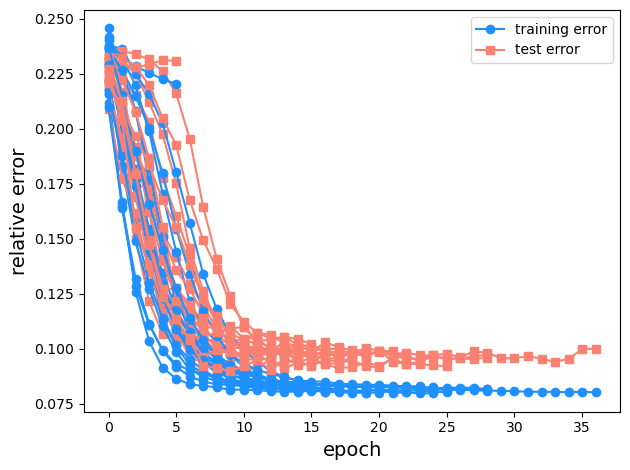

In [71]:
# plot the relative DAS training and test error for the last replica network
plot_errors(results_das)

### Get training results

In [72]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. 

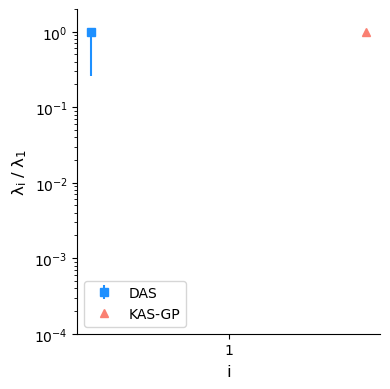

In [73]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_esmacs.csv')
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             fmt='^', color='salmon', label='KAS-GP')#, yerr = GP_std[0:n_vals])
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/esmacs_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [74]:
# run the surrogate at a number of random inputs locations drawn from U[-1, 1]
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])

In [75]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

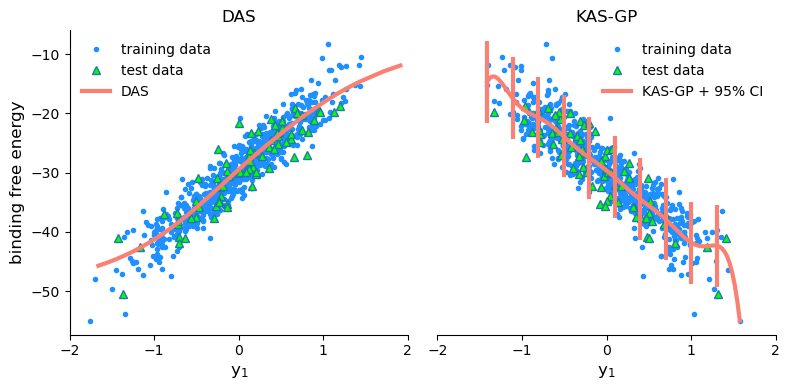

In [76]:
# QoI labels
lbl = {QoI: r'binding free energy'}

# plot DAS surrogate
fig = plt.figure(figsize=(8,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])

ax = fig.add_subplot(spec[0],  xlim=[-2,2], title='DAS')
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, '.', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', markerfacecolor='lime', label='test data') 
ax.plot(y_val_das[idx,0], das_samples_pred[idx], color='salmon', label='DAS', linewidth=3)
leg = ax.legend(loc=0, frameon=False)

ax2 = fig.add_subplot(spec[1], sharex = ax, ylim = ax.get_ylim(), title='KAS-GP') 
ax2.set_xlabel(r'$y_1$', fontsize=12)

# also plot GP surrogate from file
y_mean = das_surrogate.neural_net.y_mean
y_std = das_surrogate.neural_net.y_std
GP_surrogate = np.load('./GP_surrogate/esmacs_result.npy', allow_pickle=True).item()
ax2.plot(GP_surrogate['reduced_train_params'], samples_train, '.', color='dodgerblue', label='training data')
ax2.plot(GP_surrogate['reduced_test_params'], samples_test, '^', markerfacecolor='lime', label='test data')
ax2.plot(GP_surrogate['active_subspace'], GP_surrogate['prediction_mean'] * y_std + y_mean, color='salmon',
        label='KAS-GP + 95% CI', linewidth=3)
skip=10
ax2.errorbar(GP_surrogate['active_subspace'][0:-1:skip].flatten(), 
             GP_surrogate['prediction_mean'][0:-1:skip].flatten() * y_std + y_mean,
             yerr = GP_surrogate['prediction_CI'][0:-1:skip].flatten() * y_std, color='salmon',
             linewidth=0, elinewidth=3)
leg = ax2.legend(loc=0, frameon=False)

sns.despine(top=True, ax=ax)
sns.despine(top=True, ax=ax2)
sns.despine(left=True, ax=ax2)
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('./images/esmacs_surrogate_d%d.png' % (d, ))

### Recreate the global-derivative based sensitivity plots

In [77]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_esmacs.csv')

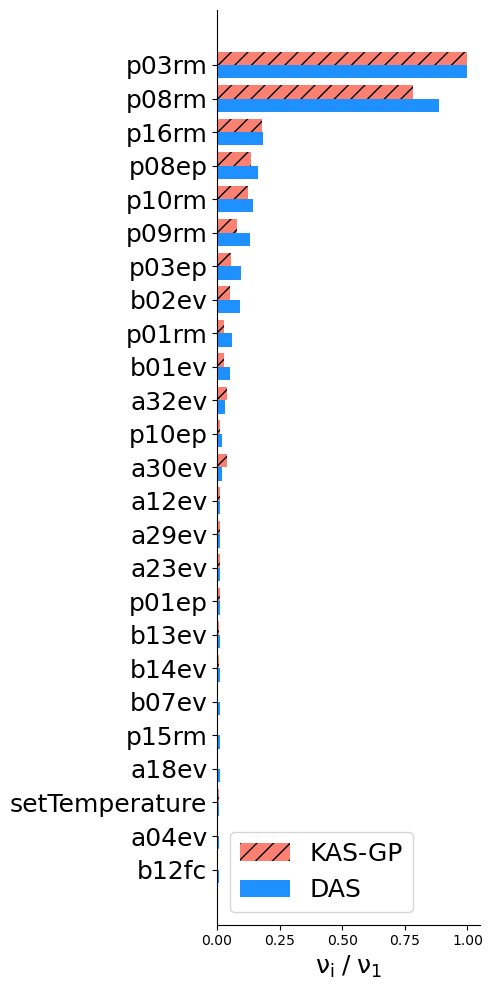

In [78]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


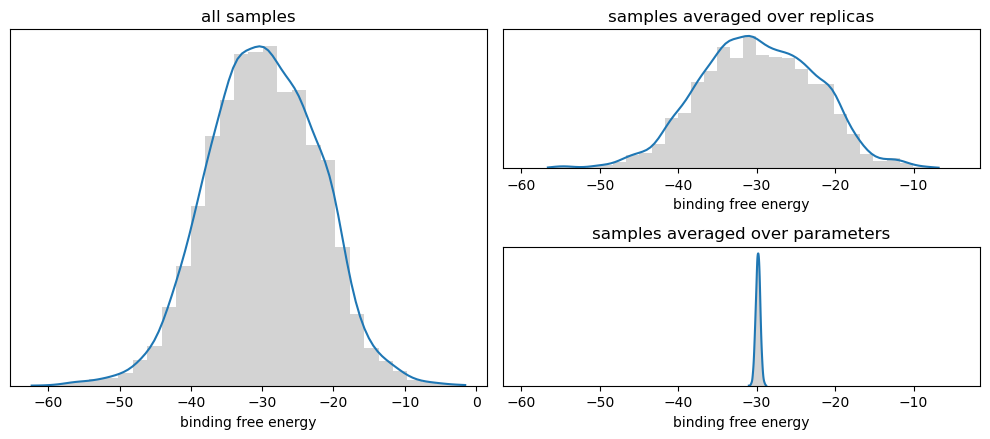

In [79]:
plot_dist(output, 'binding free energy')

### (Non-Gaussian) stats with bootstrapping

In [80]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:51<00:00, 431.50it/s]


In [81]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [82]:
print("Mean: %.2e (%.2e/%.2e)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2e (%.2e/%.2e)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.3f/%.3f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: -2.99e+01 (-2.99e+01/-2.98e+01)
Std dev: 7.68e+00 (7.61e+00/7.74e+00)
Skew: -0.08 (-0.117/-0.050)
Kurt: 0.07 (0.00/0.14)
N_samples = 18400
